## Credo AI Lens Reproduction of ProPublica

Reproducing analyses from [ProPublica's analysis of COMPAS](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). Analyses are not exact - for instance, some of the data selection has been simplified and we only reproduce the "general recidivism" analyses. Violent recidivism requires the outcome and compas labels to be changed.

In [1]:
import pandas as pd
from credoai.artifacts import ClassificationModel, DummyClassifier, TabularData
from credoai.lens import Lens
import credoai.evaluators as evl
from credoai.governance import Governance

### Prepare data

Minor preprocessing. Restrict data to only caucasian and african-american for readability.

In [2]:
raw_data = pd.read_csv('data/compas-scores-two-years.csv')

df = raw_data[raw_data.days_b_screening_arrest.between(-30,30)]
df['duration'] = df['end'] - df['start']
df = df[df['race'].isin(['Caucasian', 'African-American'])]
df['RACE'] = df['race'].astype('category').cat.reorder_categories(['Caucasian', 'African-American'])

# for general recidvisim
outcome_col = 'two_year_recid'
compas_classification = 'score_text'
compas_score = 'decile_score'

# for violent recidivism
# outcome_col = 'is_violent_recid'
# compas_classification = 'v_score_text'
# compas_score = 'v_decile_score'

### Set up Lens Artifacts

In [3]:
# set up models

# pseudo binary classification using the COMPAS classifications and score
tmp = DummyClassifier(predict_output = (df[compas_classification] != "Low").astype(int), 
                      predict_proba_output = df[compas_score])
recidivism_model = ClassificationModel('COMPAS Recidivism', tmp)

In [4]:
# set up data
sensitive_features = ['RACE']

to_drop = [outcome_col] + sensitive_features + df.columns[df.isnull().sum()>1].tolist()
recidivism_data = TabularData('ProPublica COMPAS', X=df.drop(to_drop, axis=1), 
                         y=df[outcome_col], sensitive_features=df[sensitive_features])


## Lens runs

A policy pack defined on the Responsible AI Platform determines evidence requirements. Each evidence requirement is specified in such a way that evaluations Lens performs can be associated with the evaluation. This allows Governance to affect analysis through configuration of Lens, and Lens to easily associate its analyses with particular governance requirements.

In [5]:
use_case_name = 'COMPAS Recidivism Algorithm'
policy_pack_key = 'COMPAS'
gov = Governance()
gov.register(use_case_name=use_case_name, policy_pack_key=policy_pack_key)


2022-10-10 23:31:10,080 - lens - INFO - Successfully registered with 17 evidence requirements


### Manual Creation of Pipeline

Below the evaluator pipeline is specified by the analyst. It is also possible for Lens to generate the evaluator pipeline directly from governance, as shown in the commented-out code.

In [6]:
metrics = ['true_positive_rate', 'false_positive_rate', 'false_negative_rate', 'average_precision_score', 'roc_curve', 'pr_curve']
pipeline = [evl.Performance(metrics), 
            evl.ModelFairness(metrics), 
            evl.ModelEquity(),
            evl.ModelEquity(True),
            evl.SurvivalFairness()]

lens = Lens(model=recidivism_model, assessment_data=recidivism_data, pipeline=pipeline).run()

# no pipeline is needed when governance is specified
# lens = Lens(model=recidivism_model, assessment_data=recidivism_data, governance=gov).run()

2022-10-10 23:31:10,184 - lens - INFO - Evaluator Performance added to pipeline. 
2022-10-10 23:31:10,273 - lens - INFO - Evaluator ModelFairness added to pipeline. Dataset used: assessment_data. Sensitive feature: RACE
2022-10-10 23:31:10,281 - lens - INFO - Evaluator ModelEquity added to pipeline. Sensitive feature: RACE
2022-10-10 23:31:10,289 - lens - INFO - Evaluator ModelEquity added to pipeline. Sensitive feature: RACE
2022-10-10 23:31:10,290 - lens - INFO - Evaluator SurvivalFairness added to pipeline. Sensitive feature: RACE
2022-10-10 23:31:10,291 - lens - INFO - Running evaluation for step: Performance_c312a1
2022-10-10 23:31:10,292 - lens - INFO - Running evaluation for step: ModelFairness_9bdfda
2022-10-10 23:31:10,302 - lens - INFO - Running evaluation for step: ModelEquity_ddd88d
2022-10-10 23:31:10,392 - lens - INFO - Running evaluation for step: ModelEquity_639227
2022-10-10 23:31:10,399 - lens - INFO - Running evaluation for step: SurvivalFairness_e464d5


In [7]:
# if governance was passed to Lens directly, these two lines would be unnecessary
lens.gov = gov
lens.send_to_governance()

# finally, export the evidence to the Responsible AI Platform
gov.export()

2022-10-10 23:31:10,984 - lens - INFO - Sending evidence to governance. Adding to existing evidence.
2022-10-10 23:31:11,017 - lens - INFO - Uploading 31 evidences.. for use_case_id=SkYwe6jQoAUE4MrW5G4y5E policy_pack_id=COMPAS+1
2022-10-10 23:31:11,702 - lens - INFO - Export succeeded with no issues


True

## Supplemental Plots

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("Paired", n_colors=8)
palette=[palette[i] for i in [0,1,4,5]]
sns.set_context('talk')

In [9]:
evaluator_keys = list(lens.get_results().keys())
evaluator_keys

['Performance_c312a1',
 'ModelFairness_9bdfda',
 'ModelEquity_ddd88d',
 'ModelEquity_639227',
 'SurvivalFairness_e464d5']

### Equity Analysis Plots

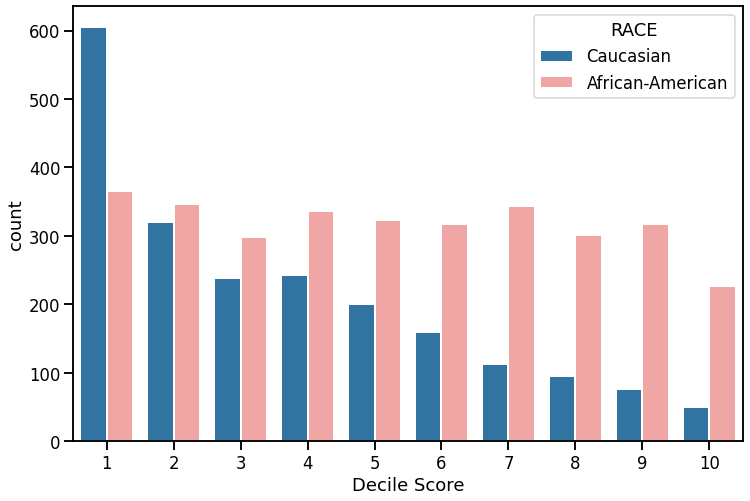

In [10]:
results = lens.get_results()[evaluator_keys[3]][1]
decile_histograms = plt.figure(figsize=(12, 8))
sns.barplot(data=results, x='predicted probability two_year_recid', y='count', hue='RACE', palette=palette[1:3], edgecolor='w', lw=2)
plt.xlabel("Decile Score")
decile_histograms.savefig('plots/decile_histograms.png')

### Survival Analysis Plots

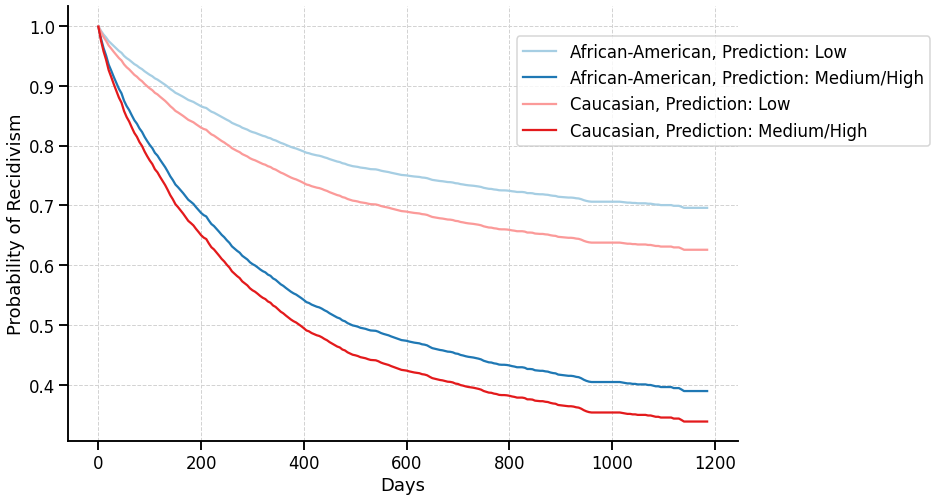

In [12]:
results = lens.get_results()[evaluator_keys[-1]][4]
labels = results['RACE'].str.cat(', Prediction: ' + results['predictions'].replace({0:"Low", 1:"Medium/High"}))
survival_plot = plt.figure(figsize=(12,8))
sns.lineplot(data=results,
             x='time_step',
             y='value',
             hue=labels,
             ci=None,
             palette=palette)
plt.legend(bbox_to_anchor=(1.3, .95))
plt.ylabel("Probability of Recidivism")
plt.xlabel("Days")
plt.grid(lw=1, ls='--', color='lightgrey')
sns.despine()
survival_plot.savefig('plots/survival_plot.png', )